In [44]:
import json
import pickle
import numpy as np
import scipy
from scipy.special import softmax
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

## Load attention matrices and key query vectors

+sanity checks

In [4]:
attention_pickle = '../BertAA/entest_4bert_akq.pkl'
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)  # add, encoding="latin1") if using python3 and downloaded data

data = load_pickle(attention_pickle)
n_docs = len(data)

In [5]:
data[213]['attns'].shape

(12, 12, 5, 5)

In [6]:
data[213]['queries'].shape

(12, 12, 5, 64)

In [7]:
data[213]['keys'].shape

(12, 12, 5, 64)

In [12]:
data[213]['tokens']

['[CLS]', 'never', 'again', '!', '[SEP]']

In [10]:
k_213 = np.transpose(data[213]['keys'], axes=[0,1,3,2])
q_213 = data[213]['queries']
a_213 = data[213]['attns']

abis_213 = np.matmul(q_213, k_213)

In [11]:
np.allclose(a_213, abis_213/ np.sqrt(64),atol=0.01)

True

## Define KQ embedding based on syntactic heads

In [59]:
def to_bpe(tokens):
    txt_line = (' ').join(tokens)
    txt_line = txt_line.replace(' ##', '@@ ')
    return txt_line.split(' ')

def aggregate_subtoken_embeddings(embeddings, wordpieces):
    # this functions connects subtokens and aggregates their attention.
    aggregate_wps = []
    wp_ids = []
    for wp_id, wp in enumerate(wordpieces):
        wp_ids.append(wp_id)
        if not wp.endswith('@@'):
            aggregate_wps.append(wp_ids)
            wp_ids = []

    res_embeddings = np.zeros((len(wordpieces), embeddings.shape[1]))

    for tok_id, wp_ids in enumerate(aggregate_wps):
        res_embeddings[tok_id,: ] = np.mean(embeddings[wp_ids, :], axis=0)

    words = ' '.join(wordpieces).replace('@@ ', '')
    res_tokens = words.split()
    assert len(res_tokens) == len(aggregate_wps), "Result matrix and token dimesnions don't match"
    return res_embeddings

In [99]:
#key and vector embeddings are summed together
#kq embedding is concatination (maybe sum) of these vectors in the syntactic heads.
#chosen by the best uas for: (determiners,) subbjects (and objects) . Convention: ([Layers],[Heads]).
#syntactic_heads = ([7,3,6,4,7,8,7,6,3], [10,9,6,10,11,10,9,9,11])
syntactic_heads = ([4,7,8], [10,11,10])
kq_embs = []

for exmpl in data:
    keys = exmpl['keys']
    queries = exmpl['queries']
    tokens = to_bpe(exmpl['tokens'])[1:-1]
    sentence_kq_embs = keys[syntactic_heads[0],syntactic_heads[1], 1:-1, :] + queries[syntactic_heads[0],syntactic_heads[1],1:-1,:]
    sentence_kq_embs = np.hstack(sentence_kq_embs)
    #sentence_kq_embs = np.sum(sentence_kq_embs, axis=0)
    sentence_kq_embs /= 8
    
    sentence_kq_embs = aggregate_subtoken_embeddings(sentence_kq_embs, tokens)
    kq_embs.append(sentence_kq_embs)


In [100]:
kq_embs[213].shape

(3, 192)

In [101]:
np.matmul(kq_embs[213],kq_embs[213].transpose())

array([[9.46411322, 6.71346695, 4.37293292],
       [6.71346695, 8.03807312, 3.9452508 ],
       [4.37293292, 3.9452508 , 7.13644869]])

## Load dependency relations from conllu

In [102]:
import dependency

In [103]:
token_file_name = '../BertAA/source.txt'
conllu_file_name = '../data/entest.conllu'

with open(token_file_name) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
words_lists = []
for tokens_list in tokens_loaded:
    words = ' '.join(tokens_list).replace('@@ ', '')
    words_lists.append(words.split())


# in dependency_rels for each sentece there is a lists of tuples (token, token's head)
# in dependency_rels_rev tuples are reversed.
dependency_rels = dependency.read_conllu(conllu_file_name, directional=True)



## Check what KQ embeddin "learned" about relations

In [104]:
def plot_similarity(kq_embs,words_lists):
    choices = np.random.choice(len(kq_embs), 9)
    fig, axes = plt.subplots(3,3,figsize=(18,18))
    for  ch, ax in zip(choices, axes.ravel()):
        matrix = np.matmul(kq_embs[ch],kq_embs[ch].transpose())
        np.fill_diagonal(matrix, 0)

        im = ax.imshow(matrix,cmap='Blues')
        ax.set_xticks(np.arange(len(words_lists[ch])))
        ax.set_yticks(np.arange(len(words_lists[ch])))
        ax.set_xticklabels(words_lists[ch], rotation=45)
        ax.set_yticklabels(words_lists[ch])
    plt.show()

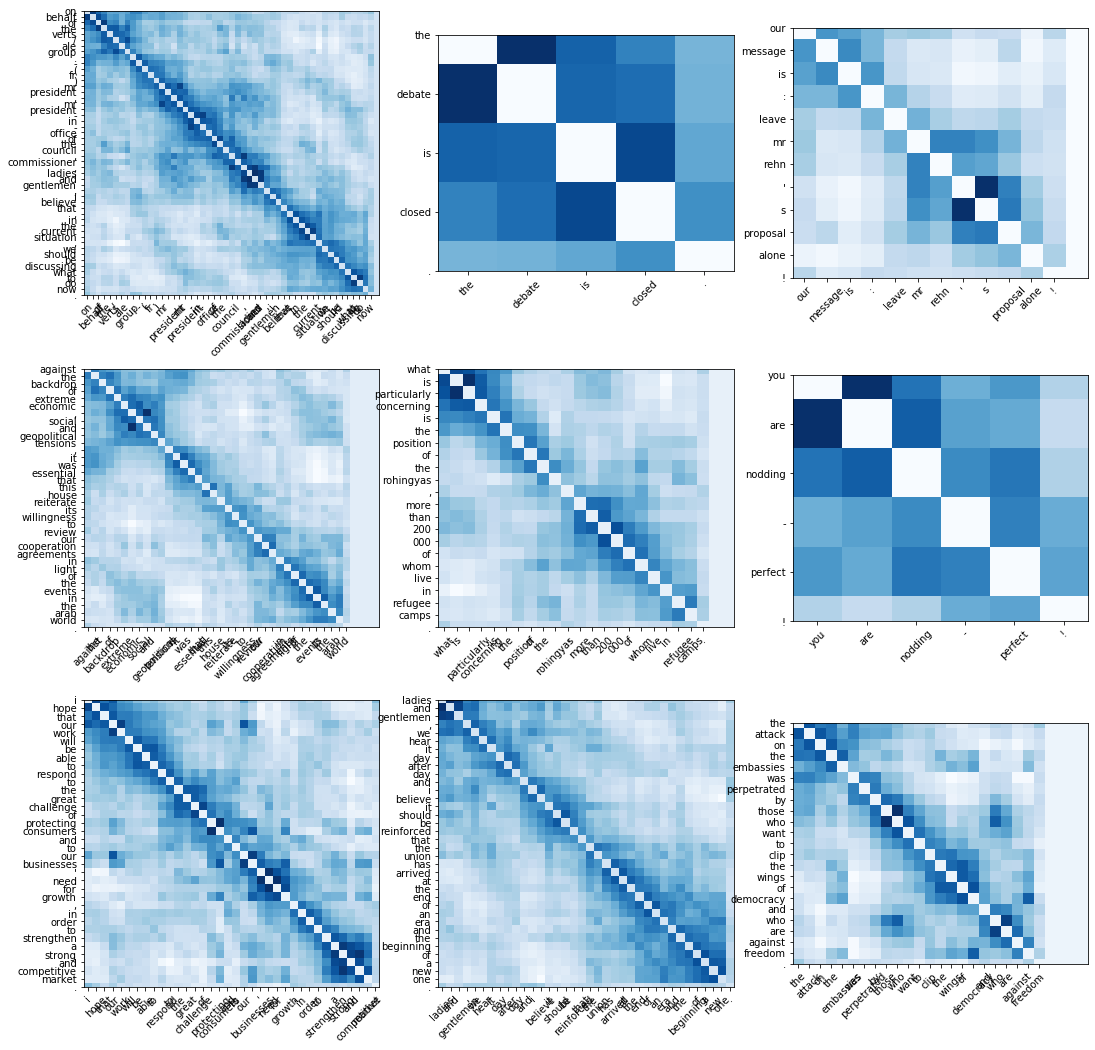

In [106]:
plot_similarity(kq_embs, words_lists)